## Import Libraries

In [1]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Connect to MongoDB and Load Data

In [2]:
# MongoDB connection
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client["kafka_streaming"]

# Load orders collection
orders_cursor = db["orders"].find()
orders_df = pd.DataFrame(list(orders_cursor))

# Convert timestamp to datetime
orders_df['timestamp'] = pd.to_datetime(orders_df['timestamp'])

# Load sales forecast collection (if exists)
forecast_cursor = db["sales_forecast"].find()
forecast_df = pd.DataFrame(list(forecast_cursor))

if not forecast_df.empty:
    forecast_df['date'] = pd.to_datetime(forecast_df['date'])


In [9]:
forecast_cursor = db["sales_forecast"].find()
for doc in forecast_cursor:
    print(doc)

{'_id': ObjectId('683471f16a58dd69669a9c42'), 'date': '2025-05-25', 'predicted_sales': 846.8194560460747}
{'_id': ObjectId('683471f16a58dd69669a9c43'), 'date': '2025-05-26', 'predicted_sales': 844.4783482030035}
{'_id': ObjectId('683471f16a58dd69669a9c44'), 'date': '2025-05-27', 'predicted_sales': 843.8120332852006}
{'_id': ObjectId('683471f16a58dd69669a9c45'), 'date': '2025-05-28', 'predicted_sales': 843.6355330981315}
{'_id': ObjectId('683471f16a58dd69669a9c46'), 'date': '2025-05-29', 'predicted_sales': 843.6000193677843}
{'_id': ObjectId('683471f16a58dd69669a9c47'), 'date': '2025-05-30', 'predicted_sales': 843.710274745524}
{'_id': ObjectId('683471f16a58dd69669a9c48'), 'date': '2025-05-31', 'predicted_sales': 843.8935927547515}


In [16]:
print("Actual sales dates:")
print(daily_sales['date'].min(), "→", daily_sales['date'].max())

print("Forecast dates:")
print(forecast_df['date'].min(), "→", forecast_df['date'].max())

Actual sales dates:
1970-01-04 → 2025-05-24
Forecast dates:
1970-01-04 00:00:00 → 2025-05-24 00:00:00


In [17]:
print(forecast_df.columns)

Index(['date', 'total_sales', 'predicted_sales'], dtype='object')


## Aggregate Daily Sales

In [15]:
# Aggregate daily sales (actual)
daily_sales = orders_df.groupby(orders_df['timestamp'].dt.date)['price'].sum().reset_index()
daily_sales.rename(columns={'timestamp': 'date', 'price': 'total_sales'}, inplace=True)


## Plot Historical Sales

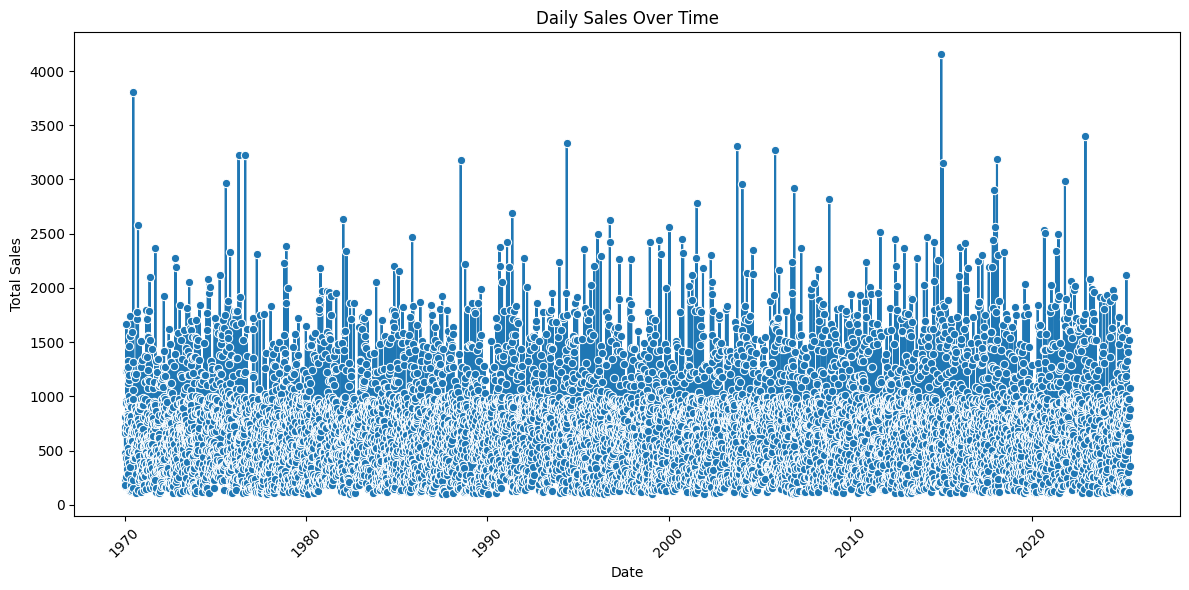

In [4]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_sales, x='date', y='total_sales', marker='o')
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plot Forecast vs. Actual (if available)

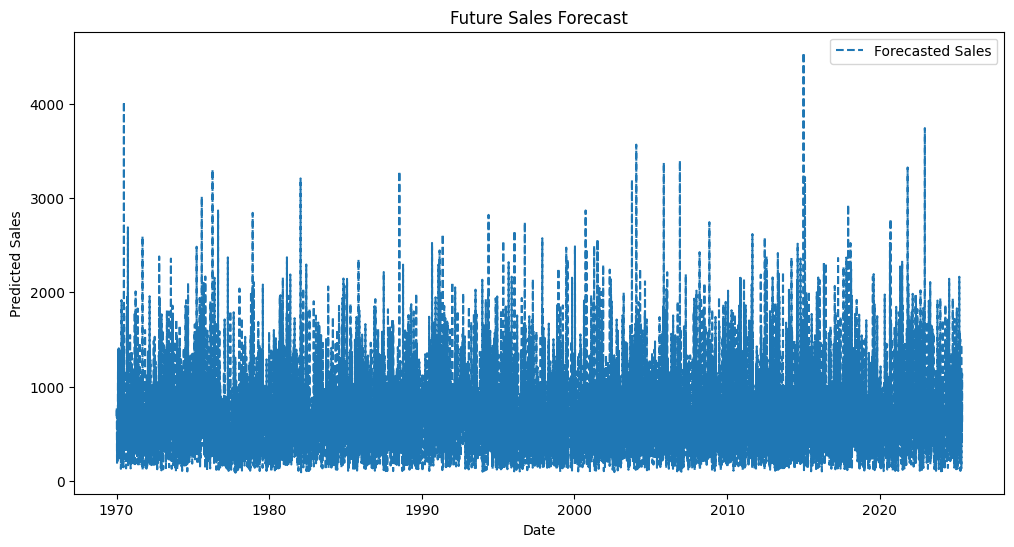

In [25]:
forecast_df['date'] = pd.to_datetime(forecast_df['date'])
plt.figure(figsize=(12,6))
plt.plot(forecast_df['date'], forecast_df['predicted_sales'], label='Forecasted Sales', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.title('Future Sales Forecast')
plt.legend()
plt.show()



## Calculate Basic Error Metrics (Optional)

In [7]:
if not forecast_df.empty:
    # Ensure both 'date' columns are datetime
    daily_sales['date'] = pd.to_datetime(daily_sales['date'])
    merged = pd.merge(daily_sales, forecast_df, on='date', how='inner')
    merged['error'] = merged['total_sales'] - merged['predicted_sales']
    mae = merged['error'].abs().mean()
    print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Absolute Error (MAE): nan


## Prepare for Explainability Phase

In [8]:
# Save merged dataset for XAI phase (SHAP/LIME)
merged.to_csv("merged_sales_forecast.csv", index=False)
print("Saved merged sales + forecast data to merged_sales_forecast.csv for explainability analysis.")


Saved merged sales + forecast data to merged_sales_forecast.csv for explainability analysis.
